# Catchment delineation
In this Notebook, using a DEM we aim to delineate the area—referred to as a catchment, watershed, or basin—that drains or contributes water to a specific point known as the catchment outlet. This will be our area of study from now on.

The steps in catchment delineation typically involve:

1. **Topographical Analysis**: Using topographic maps or digital elevation models (DEMs) to identify natural drainage paths.
2. **Flow Direction and Accumulation**: Determining the direction of water flow across the landscape by analyzing the slope and elevation of each point in the DEM.
3. **Outlet Identification**: Selecting an outlet or "pour point" where water exits the catchment.
4. **Boundary Definition**: Tracing the ridgeline or divide around the pour point to outline the catchment area.

Catchment delineation can be done manually using maps or more commonly through GIS (Geographic Information Systems) software, which automates the process by processing DEMs.

<left><img src="images/catchment.png" width="800px">

## Import (or load) the necessary libraries and iMPACT-tools
These tools will let us delineate and plot the catchment and save the results.
##### Step 1: `Import tools`

In [1]:
import numpy as np
from numba import njit
from ipywidgets import fixed, interactive
import pandas as pd
import matplotlib.pyplot as plt
# Import the necessary iMPACT-tools
from tools.catchment_delineation import plot_catchment_delineation
from tools.file_IO import open_raster, save_as_raster
from tools.plot_dem import plot3d_dem
from tools.dem_analysis import slope_gradient
from tools.flow_accumulation import flow_accumulation_D8, flow_accumulation_Dinf

## Function for catchment delineation
In simple terms, the function `catchment_delineation` helps you understand how water flows over a landscape (DEM) and shows you the exact area that will contribute water to a particular outlet.
1. **Define outlet**: first we define a specific point on the map where the water flows out, called the catchment "outlet." 
2. **Trace the water flow**: beginning at the outlet, the function looks at all the nearby areas to check which ones flow towards the outlet, or in other words, it looks for cells of the DEM that are connected to the outlet. 
3. **Mark the catchment cells**: when the function finds a cell where water flows towards the outlet, it marks that cell as part of the catchment. 
4. **Keep Exploring**: it then continues to check the neighboring cells.
5. **Delineation of the catchment area**: once all cells have been checked, the function gives you a final map. This map shows you the entire catchment area – all the land that will drain water into the outlet.

In [2]:
@njit
def catchment_delineation(dem,flow_direction, outlet_row, outlet_col):
    """
    Delineates the catchment area based on flow direction and the location of the catchment outlet.

    Args:
        dem (numpy.ndarray): 2D array of the digital elevation model.
        flow_direction (numpy.ndarray): 2D array representing flow direction values.
        outlet_row (int): Row index of the catchment outlet cell.
        outlet_col (int): Column index of the catchment outlet cell.

    Returns:
        catchment_mask (numpy.ndarray): Binary mask indicating the delineated catchment area.
        catchment_dem (numpy.ndarray: DEM of the delineated catchment area
    """
    
    ######################
    ### Initialization ###
    ######################
    # Initialize a mask (boolean array) to track visited cells during reverse tracing
    visited = np.zeros_like(flow_direction, dtype=np.bool_)

    # Initialize the catchment mask (boolean array) to represent the catchment area
    catchment_mask = np.zeros_like(flow_direction, dtype=np.bool_)*np.nan

    #######################
    ### Reverse tracing ###
    #######################   
    # Start reverse tracing from the outlet cell and explores neighboring cells recursively
    
    # Create the variable stack to keep track of the cells that need to be explored during the reverse tracing process.
    stack = [(outlet_row, outlet_col)] # Add the first catchment cell (outlet) to the stack
    
    while stack: # It continues this process while there are cells (in stack) to explore.
        
        current_row, current_col = stack.pop() # return and remove the last item from the stack

        # Check if the current cell has been visited
        if visited[current_row, current_col]:
            continue

        # Mark the current cell as visited
        visited[current_row, current_col] = True

        # Mark the current cell as part of the catchment
        catchment_mask[current_row, current_col] = 1
        
        ##########################
        ### Neighbor Selection ###
        ##########################

        # Define a 3x3 array to represent the directions of the valid neighboring cells (connected to the current cell)
        neighbours_dir = np.array([(2,    4,  8),
                                   (1,    0, 16),
                                   (128, 64, 32)], dtype=np.int32)

        # Iterate over neighboring cells in a 3x3 grid centered around the current cell
        
        neighboring_cells = [] # Initialize the variable to add valid neighboring cells
        
        for dr in range(-1, 2): # change in the row index (-1: move up, 0: stay, 1: move down)
            for dc in range(-1, 2): # change in the column index (-1: move left, 0: stay, 1: move right)
                
                if dr == 0 and dc == 0: # exclude the current cell itself
                    continue
                    
                new_row, new_col = current_row + dr, current_col + dc
                
                # Determine valid neighboring cells: check if each neighboring cell satisfies certain conditions
                if (0 <= new_row < flow_direction.shape[0] and # It's within the bounds of the array.
                    0 <= new_col < flow_direction.shape[1] and # It's within the bounds of the array.
                    not visited[new_row, new_col] and # It hasn't been visited yet.
                    flow_direction[new_row, new_col] == neighbours_dir[dr+1, dc+1]): # Its flow direction matches neighbours_dir.         
                    
                    neighboring_cells.append((new_row, new_col)) # Valid neighboring cells are added
        
        #############################
        ### Recursive Exploration ###
        #############################
        # Add all the valid neighboring cells to the stack for further exploration
        stack.extend(neighboring_cells)
        
    catchment_dem = dem*catchment_mask

    # Return the catchment_mask, a boolean array indicating the delineated catchment area
    return catchment_mask,catchment_dem

## Load the DEM, flow direction and flow accumulation of the area of study

<left><img src="images/open_raster.png" width="200px">
##### Step 2: `Open the files and plot: DEM, flow direction and flow accumulation maps`

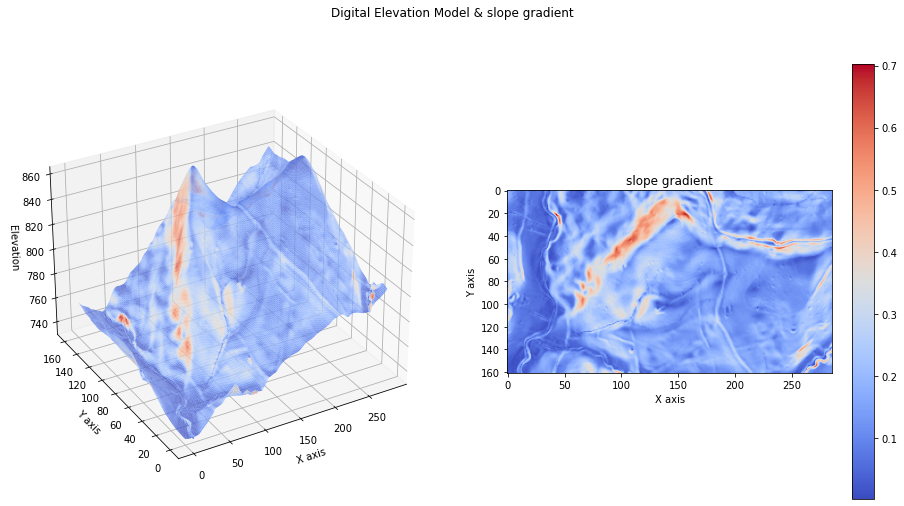

In [3]:
dem, dem_metadata = open_raster('inputs/dem/','filled_dem.tif')
dem_resol= dem_metadata['transform'][0]
slope = slope_gradient(dem, dem_resol)
plot3d_dem(dem,slope,'slope gradient')

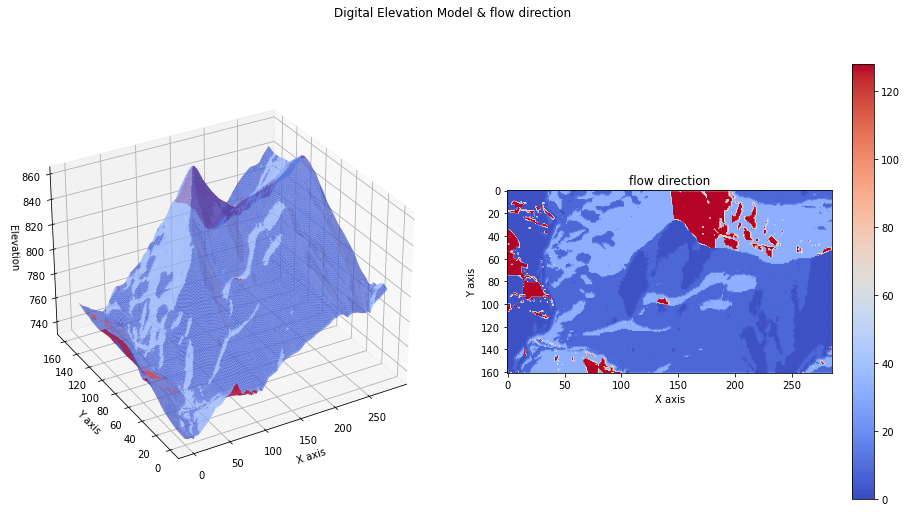

In [4]:
flow_dir_D8,flow_acc_D8,flow_rout_up_row_D8, flow_rout_up_col_D8, flow_rout_down_row_D8, flow_rout_down_col_D8, flow_rout_contrib_D8, flow_rout_slope_D8 = flow_accumulation_D8(dem,slope,dem_resol)
# Plot the 3D DEM with flow direction
plot3d_dem(dem,flow_dir_D8,'flow direction')

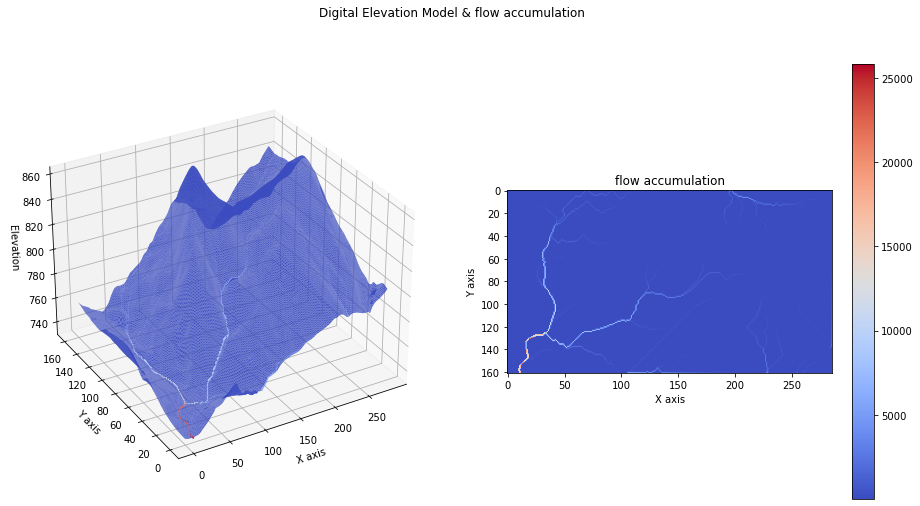

In [5]:
# Plot the 3D DEM with flow accumulation
plot3d_dem(dem,flow_acc_D8,'flow accumulation')

## Interactive plotting function for catchment delineation
In this section, we provide an interactive tool to visualize the catchment delineation process. This interactive widget allows you to select the catchment outlet using a slider. By adjusting this slider, you can see how the catchment area changes based on the outlet's position.

<left><img src="images/catchment_delineation.png" width="400px">

##### Step 3: `Interactive catchment delineation: using the slider select the catchment outlet`

In [6]:
# Interactive plot with widgets (sliders) for selecting the catchment outlet
iplot = interactive(plot_catchment_delineation,dem = fixed(dem), fd = fixed(flow_dir_D8), fa = fixed(flow_acc_D8),outlet = (1,400))
display(iplot)

interactive(children=(IntSlider(value=1, description='outlet', max=400, min=1), Output()), _dom_classes=('widg…

## Run the function to compute the slope gradient of the delineated catchment
##### Step 4: `Calculate the slope gradient of the DEM`

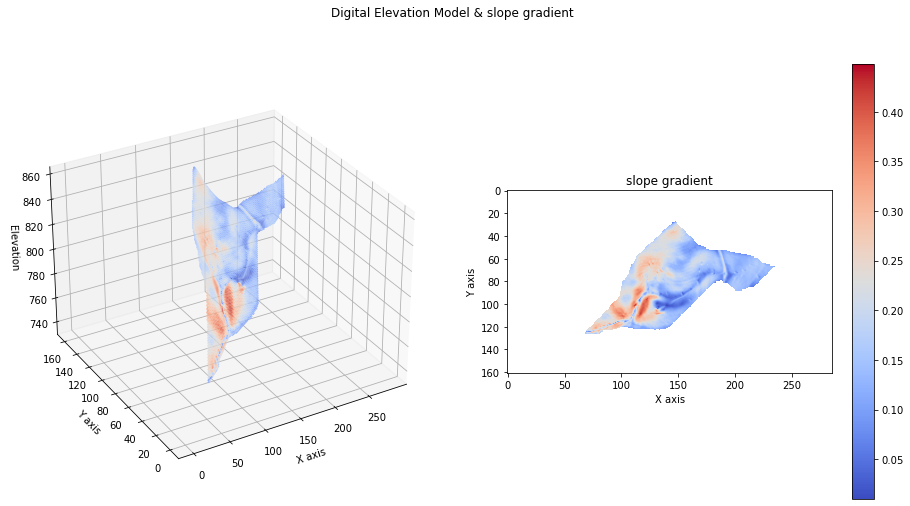

In [7]:
catchment_mask,catchment_dem = iplot.result
slope = slope_gradient(catchment_dem, dem_resol)
# Plot the 3D DEM with slope gradients
plot3d_dem(dem,slope,'slope gradient')

## Run the function to compute the slope, flow accumulation, flow direction and flow routing for the delineated catchment
Here we use the D8 method
##### Step 5a: `Run the D8 function`

C:\Users\Usuario\OneDrive - Universidad de Córdoba\Projects\iMPACT\iMPACT-erosion\iMPACT-Start\tools\plot_dem.py:39: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(x, y, np.flipud(dem),


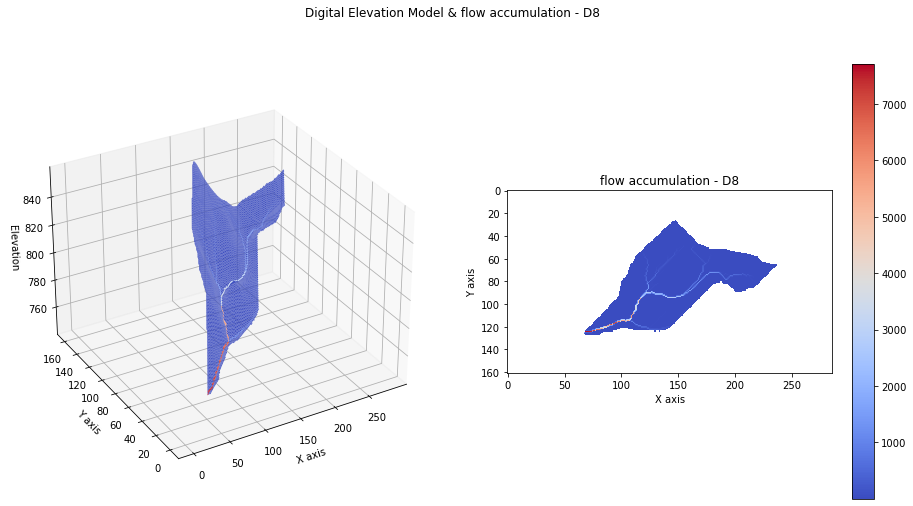

In [8]:
flow_dir_D8,flow_acc_D8,flow_rout_up_row_D8, flow_rout_up_col_D8, flow_rout_down_row_D8, flow_rout_down_col_D8, flow_rout_contrib_D8, flow_rout_slope_D8 = flow_accumulation_D8(catchment_dem,slope,dem_resol)
plot3d_dem(catchment_dem,flow_acc_D8,'flow accumulation - D8')

##### Step 5b: `Run the Dinf function`

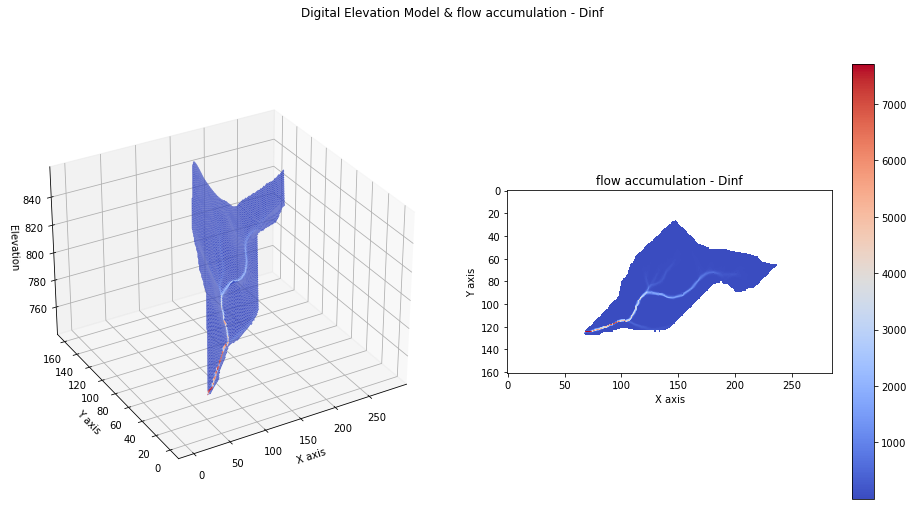

In [9]:
flow_acc_Dinf,flow_rout_up_row_Dinf,flow_rout_up_col_Dinf,flow_rout_down_row_Dinf, flow_rout_down_col_Dinf, flow_rout_contrib_Dinf, flow_rout_slope_Dinf = flow_accumulation_Dinf(catchment_dem,dem_resol)
plot3d_dem(catchment_dem,flow_acc_Dinf,'flow accumulation - Dinf')

In [10]:
def plot_stream_network(method, threshold):
    """
    Plots the stream network over a DEM and flow accumulation map based on the selected method and threshold.

    Parameters:
    - method (str): The flow accumulation method, either 'D8' or 'Dinf'.
    - threshold (int): The flow accumulation threshold to define the stream network.
    """

    # Select the appropriate flow accumulation data based on the method
    if method == 'D8':
        flow_acc = flow_acc_D8  # Flow accumulation using the D8 method
    elif method == 'Dinf':
        flow_acc = flow_acc_Dinf  # Flow accumulation using the D-Infinity method

    # Create a boolean mask where flow accumulation is below the threshold
    stream_network_mask = flow_acc <= threshold  

    # Mask the DEM and flow accumulation data using the stream network mask
    masked_dem = np.where(stream_network_mask, dem, np.nan)  # Hide non-stream areas in DEM
    masked_flow_acc = np.where(stream_network_mask, flow_acc, np.nan)  # Hide non-stream areas in flow accumulation

    # Extract grid resolution from DEM metadata
    grid_resol = dem_metadata['transform'][0]  

    # Create a figure with two subplots (DEM + flow accumulation)
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))  

    # Plot the DEM with the stream network overlay
    ax[0].imshow(masked_dem, cmap='terrain')  
    ax[0].set_title(f'DEM & Stream network (Method: {method} - Threshold: {threshold} grid cells)')

    # Plot the flow accumulation with the stream network overlay
    im = ax[1].imshow(masked_flow_acc, cmap='coolwarm')  
    ax[1].set_title(f'Flow acc ({method}) & Stream Network (threshold = {threshold * grid_resol**2 / 10000:.1f} ha)')

    # Add a color bar to indicate flow accumulation intensity
    plt.colorbar(im)

    # Display the figure
    plt.show()   

# Create an interactive widget to adjust the method and threshold dynamically
interactive(plot_stream_network, method=['D8', 'Dinf'], threshold=(0, 2000))

interactive(children=(Dropdown(description='method', options=('D8', 'Dinf'), value='D8'), IntSlider(value=1000…

#### Now define the threshold
Areas where the flow accumulation is above the threshold are set to NaN, effectively masking them out. This helps visualize only the stream network.

In [92]:
# Define the flow accumulation threshold for stream network extraction
threshold = 1000  

# Apply threshold to the D8 flow accumulation grid
# Areas where flow accumulation is greater than the threshold are masked (set to NaN)
masked_flow_acc_D8 = np.where(flow_acc_D8 <= threshold, flow_acc_D8, np.nan)  

# Apply the same thresholding method to the Dinf flow accumulation grid
masked_flow_acc_Dinf = np.where(flow_acc_Dinf <= threshold, flow_acc_Dinf, np.nan) 

## Save the DEM, flow accumulation and flow direction maps of the delineated catchment as a raster file and the flow routing arrays as csv files
<left><img src="images/save_raster.png" width="200px">
##### Step 6: `Save the results`

In [14]:
file_name = 'catchment_dem'
# Save the DEM as raster (TIFF) files
save_as_raster('inputs/dem/',file_name + '.tif',catchment_dem,dem_metadata)
# Save the slope, flow direction, and flow accumulation maps as raster (TIFF) files
save_as_raster('inputs/slope/','slope_' + file_name + '.tif', slope, dem_metadata)
save_as_raster('inputs/flow_dir/','flow_dir_D8_' + file_name + '.tif', flow_dir_D8, dem_metadata)
save_as_raster('inputs/flow_acc/','flow_acc_D8_' + file_name + '.tif', flow_acc_D8, dem_metadata)
save_as_raster('inputs/flow_acc/','flow_acc_Dinf_' + file_name + '.tif', flow_acc_Dinf, dem_metadata)
save_as_raster('inputs/flow_acc/','flow_acc_D8_' + file_name + '_masked_stream.tif', masked_flow_acc_D8, dem_metadata)
save_as_raster('inputs/flow_acc/','flow_acc_Dinf_' + file_name + '_masked_stream.tif', masked_flow_acc_Dinf, dem_metadata) 

# Save the D8 flow routing data to a CSV file
df_D8 = pd.DataFrame() 
df_D8['upstream_row'] = flow_rout_up_row_D8   # Row indices of upstream cells for D8 method
df_D8['upstream_col'] = flow_rout_up_col_D8   # Column indices of upstream cells for D8 method
df_D8['downstream_row'] = flow_rout_down_row_D8  # Row indices of downstream cells for D8 method
df_D8['downstream_col'] = flow_rout_down_col_D8  # Column indices of downstream cells for D8 method
df_D8['contribution'] = flow_rout_contrib_D8   # Flow contributions from upstream to downstream cells
df_D8['slope'] = flow_rout_slope_D8 + [0]   # Slope values along the flow paths for D8 (added [0] to match length)
df_D8.to_csv('inputs/flow_rout/flow_routing_D8_' + file_name + '.csv', index=False)  # Export the DataFrame to a CSV file

# Save the D-infinity flow routing data to a CSV file
df_Dinf = pd.DataFrame()
df_Dinf['upstream_row'] = flow_rout_up_row_Dinf  # Row indices of upstream cells for D-infinity method
df_Dinf['upstream_col'] = flow_rout_up_col_Dinf  # Column indices of upstream cells for D-infinity method
df_Dinf['downstream_row'] = flow_rout_down_row_Dinf  # Row indices of downstream cells for D-infinity method
df_Dinf['downstream_col'] = flow_rout_down_col_Dinf  # Column indices of downstream cells for D-infinity method
df_Dinf['contribution'] = flow_rout_contrib_Dinf  # Flow contributions from upstream to downstream cells
df_Dinf['slope'] = flow_rout_slope_Dinf  # Slope values along the flow paths for D-infinity method
df_Dinf.to_csv('inputs/flow_rout/flow_routing_Dinf_' + file_name + '.csv', index=False)  # Export the DataFrame to a CSV file